In [36]:
#Importing required librarires
import csv
import math
import cv2

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from matplotlib import pyplot as plt

In [4]:
#configuration for memory management
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    #### When GPU is found in current running environment ####
     try:
     # Currently, memory growth needs to be the same across GPUs
         for gpu in gpus:
             tf.config.experimental.set_memory_growth(gpu, True)
             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
     except RuntimeError as e:

     # Memory growth must be set before GPUs have been initialized
         print(e)

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [5]:
#loading the data
data = np.load('images.npy')

In [6]:
#verifying the data attributes
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  (4 marks)

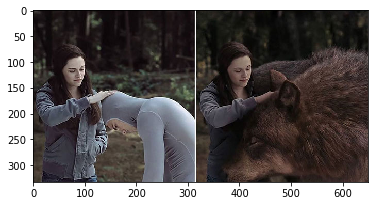

In [9]:
#visulaizing the loaded data
plt.imshow(data[0,0])
plt.show()

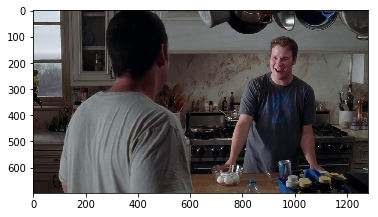

In [11]:
#some more examples of the loaded data
plt.imshow(data[1,0])
plt.show()

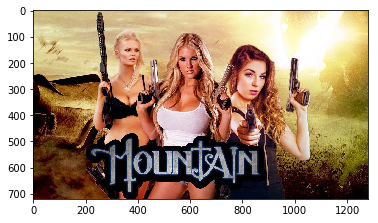

In [12]:
plt.imshow(data[100,0])
plt.show()

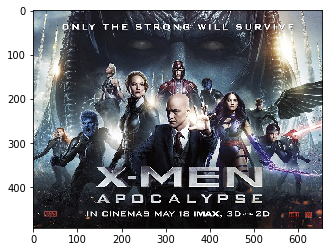

In [14]:
plt.imshow(data[408,0])
plt.show()

In [15]:
#reading the json of the mask data
data[0,1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [42]:
# setting up all the required hyperparameters
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 50
BATCH_SIZE = 4
PATIENCE = 10

THREADS = 1

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [18]:
#preprocessing the input images and the masks
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [19]:
#verifying the training data parameters
X_train.shape

(409, 224, 224, 3)

we have 409 images of size 224 x 224 and with 3 channels (RGB)

In [20]:
masks.shape

(409, 224, 224)

we have 409 masks of size 224 x 224 

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


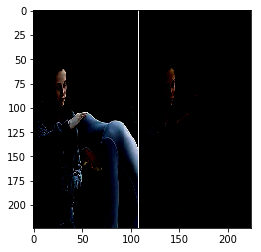

In [23]:
plt.imshow(X_train[0])
plt.show()

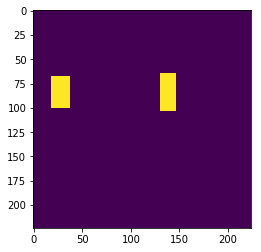

In [24]:
plt.imshow(masks[0])
plt.show()

In [60]:
print("image array :", X_train[0])

image array : [[[-0.60000002 -0.6156863  -0.51372552]
  [-0.58431375 -0.60000002 -0.49803919]
  [-0.60000002 -0.6156863  -0.51372552]
  ...
  [-0.23921567 -0.1607843  -0.24705881]
  [-0.23921567 -0.1607843  -0.24705881]
  [-0.24705881 -0.16862744 -0.25490195]]

 [[-0.58431375 -0.60000002 -0.49803919]
  [-0.58431375 -0.60000002 -0.49803919]
  [-0.58431375 -0.60000002 -0.49803919]
  ...
  [-0.23921567 -0.1607843  -0.24705881]
  [-0.23921567 -0.1607843  -0.24705881]
  [-0.24705881 -0.16862744 -0.25490195]]

 [[-0.57647061 -0.59215689 -0.49019605]
  [-0.58431375 -0.60000002 -0.49803919]
  [-0.58431375 -0.60000002 -0.49803919]
  ...
  [-0.24705881 -0.16862744 -0.25490195]
  [-0.24705881 -0.16862744 -0.25490195]
  [-0.24705881 -0.16862744 -0.25490195]]

 ...

 [[-0.7647059  -0.77254903 -0.72549021]
  [-0.75686276 -0.7647059  -0.71764708]
  [-0.74901962 -0.75686276 -0.70980394]
  ...
  [-0.65490198 -0.64705884 -0.66274512]
  [-0.68627453 -0.67058825 -0.69411767]
  [-0.70980394 -0.69411767 -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


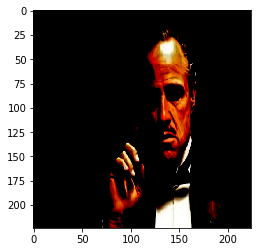

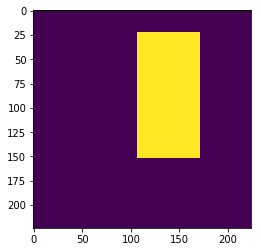

In [25]:
plt.imshow(X_train[10])
plt.show()
plt.imshow(masks[10])
plt.show()

In [26]:
# resizing the masks to 28 * 28 for faster implementation of the model
masks_resized = np.zeros((int(data.shape[0]), 28, 28))
for mask_len in range(masks.shape[0]):
 masks_resized[mask_len] = cv2.resize(masks[mask_len], (28,28))
masks.shape, masks_resized.shape

((409, 224, 224), (409, 28, 28))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


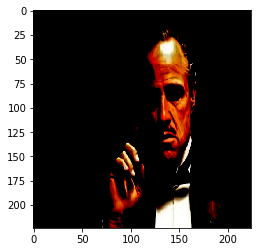

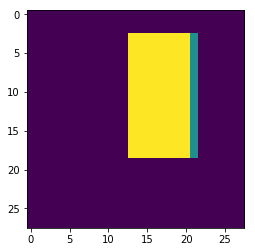

In [27]:
plt.imshow(X_train[10])
plt.show()
plt.imshow(masks_resized[10])
plt.show()

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [28]:
def create_model(trainable=True):
    #using transposed learning , using mobilenet architecture with the weights of imagenet
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

        #Unet architecture implementation
        #from mobilenet the pointwise layers are chosen , upsampled and concantenated with the layer before downsampling
    block1 = model.get_layer("conv_pw_5_relu").output #28 *28 layer before downsampling to 14 *14
    block2 = model.get_layer("conv_pw_11_relu").output #14 *14 layer before downsampling to 7 *7
    block3 = model.get_layer("conv_pw_13_relu").output #7 *7 layer 

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x) #final activation function
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x) #reshaping output to 28 * 28

    return Model(inputs=model.input, outputs=x)

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient

In [37]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

In [38]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### Call the create_model function

In [31]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 31s 2us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________

### Define checkpoint and earlystopping

In [32]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Train-test data split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, masks_resized, test_size=0.30, random_state=1)

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [39]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [43]:
model.fit(x=X_train,
 y=y_train,
 epochs=EPOCHS,
 callbacks=[checkpoint, reduce_lr, stop],
 batch_size = BATCH_SIZE,
 validation_data=(X_val, y_val), verbose=1
 )

Train on 286 samples, validate on 123 samples
Epoch 1/50
284/286 [============================>.] - ETA: 0s - loss: 1.3288 - dice_coefficient: 0.3823
Epoch 00001: loss improved from 1.59299 to 1.32639, saving model to model-1.33.h5
286/286 [==============================] - 18s 63ms/sample - loss: 1.3264 - dice_coefficient: 0.3838 - val_loss: 1.2945 - val_dice_coefficient: 0.3885
Epoch 2/50
284/286 [============================>.] - ETA: 0s - loss: 1.2272 - dice_coefficient: 0.4107
Epoch 00002: loss improved from 1.32639 to 1.22623, saving model to model-1.23.h5
286/286 [==============================] - 18s 64ms/sample - loss: 1.2262 - dice_coefficient: 0.4129 - val_loss: 1.2054 - val_dice_coefficient: 0.4252
Epoch 3/50
284/286 [============================>.] - ETA: 0s - loss: 1.1379 - dice_coefficient: 0.4421
Epoch 00003: loss improved from 1.22623 to 1.13778, saving model to model-1.14.h5
286/286 [==============================] - 19s 65ms/sample - loss: 1.1378 - dice_coefficient: 

the execution ended at 43rd epoch  with

84ms/sample - loss: 0.7463 - dice_coefficient: 0.6083 - val_loss: 0.8329 - val_dice_coefficient: 0.5881

### Get the predicted mask for a sample image   (5 marks)

In [46]:
predicted_mask = model.predict(X_train)

In [45]:
def impose_mask_3Dimage(X, mask):
 
 resized_mask = cv2.resize(mask, (X.shape[0], X.shape[1]), 1)#resizing the mask to the input image size
 mask_rgb = np.zeros_like(X)
 ### imposing mask on each channel ###
 for i in range(3):
     mask_rgb[:,:,i] = X[:,:,i] * resized_mask #wherever mask is one ,copy the input image value
 return mask_rgb

In [54]:
def plot_images(index , X , preicted_mask):
    print("Original image")
    plt.imshow(X[index])
    plt.show()
    print("Original mask")
    plt.imshow(masks[index])
    plt.show()
    print("Predicted mask")
    plt.imshow(predicted_mask[index])
    plt.show()
    print("Predicted mask imposed on original image")
    plt.imshow(impose_mask_3Dimage(X[index], predicted_mask[index]))
    plt.show()

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image


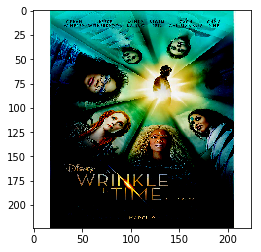

Original mask


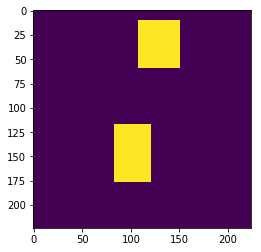

Predicted mask


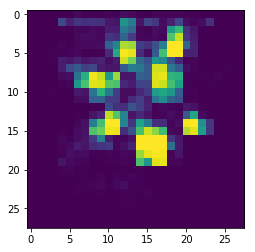

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted mask imposed on original image


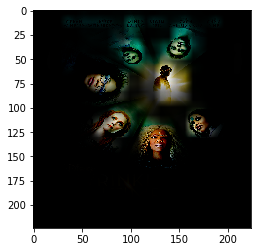

In [55]:
plot_images(5,X_train,predicted_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image


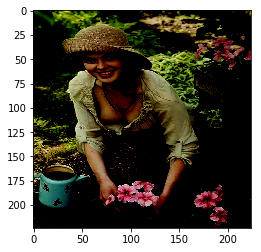

Original mask


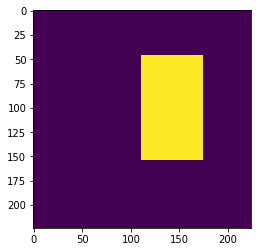

Predicted mask


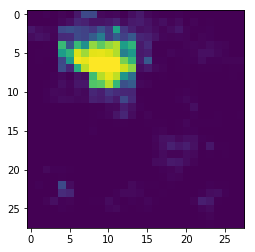

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted mask imposed on original image


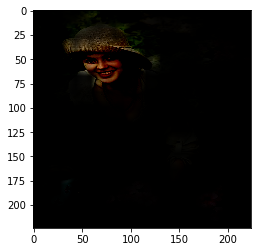

In [56]:
plot_images(20,X_train,predicted_mask)

### Conclusion
 - we have implemented the Unet layers on top of mobilenet architecture.
 - loss: 0.7463 - dice_coefficient: 0.6083 - val_loss: 0.8329 - val_dice_coefficient: 0.5881
 - Training accuracy is good but the validation accuracy is not great
 - Further, the model should be improved with deeper unet (more contraction and less expansion) 
 - On further reading , we find out the models such as UNet++ have improved accuracy and also one more paper suggests that use of dilated convulation layers improve the accuracy.